In [1]:
# Libraries
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from modules import estimate_yield as estimate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score as r2 
from sklearn.metrics import mean_absolute_error as mae 
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold
from IPython.core.interactiveshell import InteractiveShell

# Notebook Settings 
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("error")
pd.set_option('display.max_columns', 500)
InteractiveShell.ast_node_interactivity = "last_expr"
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Variables
crop_seasons = list(range(1993,2017))
months_of_crop_season = list(range(4,12))
homogeneous_groups = list(range(1,5))
models = ["ECMWF", "NCEP", "UKMO", "MME", "CLIMATE", "WS"]

### 1. Read Data

In [2]:
kfold_cv_dataset = pd.read_csv("kfold_cv_dataset.csv")
results_of_modification_steps = pd.read_csv("results_of_modification.csv")

## 2. Simulate wheat yield

In [3]:
def perform_simulations_and_compute_metrics(df):
    rmse_scores = pd.DataFrame(0, index=models, columns=months_of_crop_season)
    r2_scores = pd.DataFrame(0, index=models, columns=months_of_crop_season)
    simulations = []
    for month in months_of_crop_season:
        for model in models:
            res = estimate.kfold_cross_validation(df, model=model, init=month, no_of_features=8)
            res = res.assign(model=model, init_month=month)
            simulations.append(res)
            # rmse
            rmse_score = 100 * mse(res["yield"], res["predicted"], squared=False)/(res["yield"].mean())
            rmse_scores.loc[model, month] = np.round(rmse_score, 2)
            # coefficient of determination
            r2_score = r2(res["yield"], res["predicted"])
            r2_scores.loc[model, month] = np.round(r2_score, 2)
    
    simulations = pd.concat(simulations, ignore_index=False, axis=0)    
    return (simulations, rmse_scores, r2_scores)

In [4]:
simulations, rmse_scores, r2_scores = perform_simulations_and_compute_metrics(kfold_cv_dataset)

In [5]:
simulations.sample(2)
rmse_scores.head(5)
#r2_scores.head(5)

,4,5,6,7,8,9,10,11
ECMWF,11.56,11.90,11.23,11.44,10.58,9.49,7.88,6.01
NCEP,14.34,14.88,14.70,12.74,11.84,10.45,9.26,6.01
UKMO,12.28,12.71,10.79,12.13,11.07,10.61,7.64,6.01
MME,12.12,12.47,11.76,11.62,10.47,9.86,7.90,6.01
CLIMATE,11.75,11.75,11.75,11.75,11.75,10.27,9.13,6.01


### 3. Visualizations


#### 3.1 Results of modification steps

In [6]:
results_of_modification_steps.columns = ['exp', 'model', '4', '5', '6', '7', '8', '9', '10', '11']

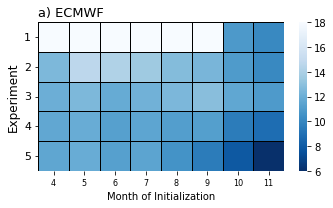

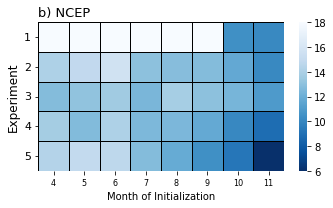

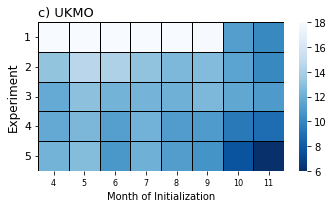

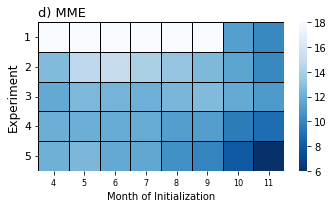

In [7]:
model_to_index = {"ECMWF":"a)", "NCEP":"b)", "UKMO":"c)", "MME":"d)"}
for model in ["ECMWF", "NCEP", "UKMO", "MME"]:
    to_plot = results_of_modification_steps.loc[(results_of_modification_steps["model"] == model)].set_index("exp").drop(columns=["model"])
    plt.figure(figsize = (5,3))
    ax = sns.heatmap(data=to_plot.round(2), annot=False, vmin=6, vmax=18, linecolor="black", linewidths=.5, fmt="g", cmap="Blues_r", annot_kws={"size":12}) # other cmap for pearson is 'mako'
    ax.set_xlabel("Month of Initialization", fontsize=10)
    ax.set_ylabel("Experiment", fontsize=12)
    ax.set_title(model_to_index[model] + " " + model, loc="left", fontsize=13)
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=11, rotation=0)
    plt.tight_layout()
    name = model + "_experiments.svg"
    #plt.savefig("images/"+name)
    plt.show();

#### 3.2 RMSE and R2 development

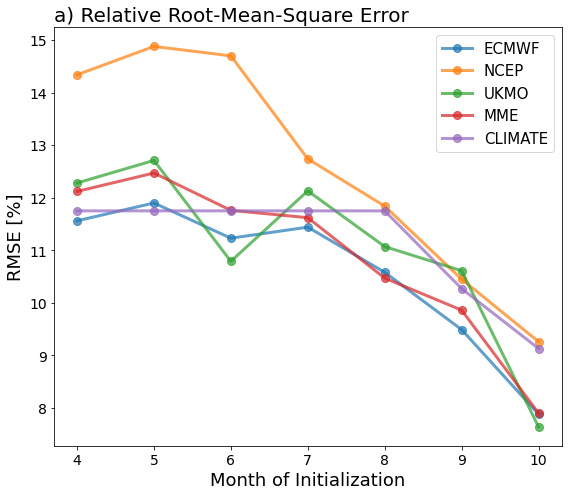

In [8]:
ax = rmse_scores.loc[rmse_scores.index != "WS", [4, 5, 6, 7, 8, 9, 10]].transpose().plot(figsize=(8,7), 
                                                                 marker='o', 
                                                                 ms=8, 
                                                                 lw=3, 
                                                                 linestyle='-', 
                                                                 alpha=.7, 
                                                                 #markerfacecolor='white',
                                                                 markeredgewidth=1, 
                                                                 legend=False)
#ax.grid('on', which='both', axis='y', linestyle='--', linewidth=.7)
#ax.grid('on', which='both', axis='x', linestyle='--', linewidth=.7)
ax.set_xlabel('Month of Initialization', fontsize=18)
#ax.set_ylabel(r'$R^{2}$', fontsize=18)
ax.set_ylabel('RMSE [%]', fontsize=18)
ax.set_title('a) Relative Root-Mean-Square Error', loc="left", fontsize=20)
#ax.set_title('b) Coefficient of Determination', loc="left", fontsize=20)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.legend(fontsize=15)
#ax.set_ylim(5.5, 16.5)
#ax.set_ylim(-0.85, 0.85)
plt.tight_layout()
#plt.savefig("images/rmsescore_development.svg")
plt.show();

#### 3.3 Graphical Analysis of residuals

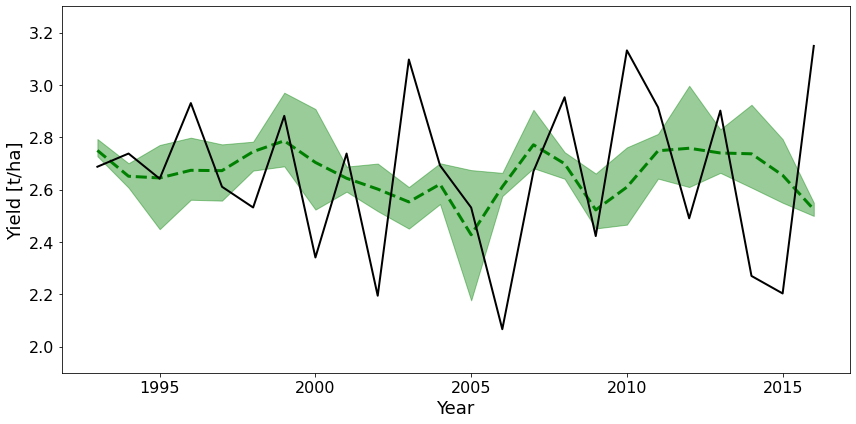

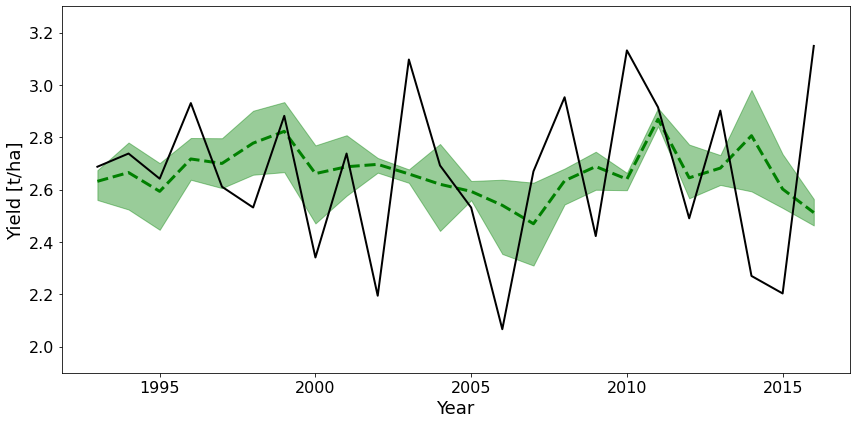

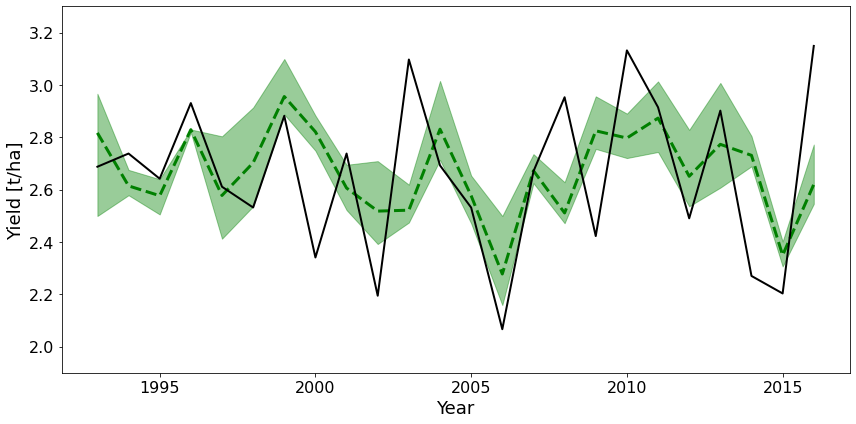

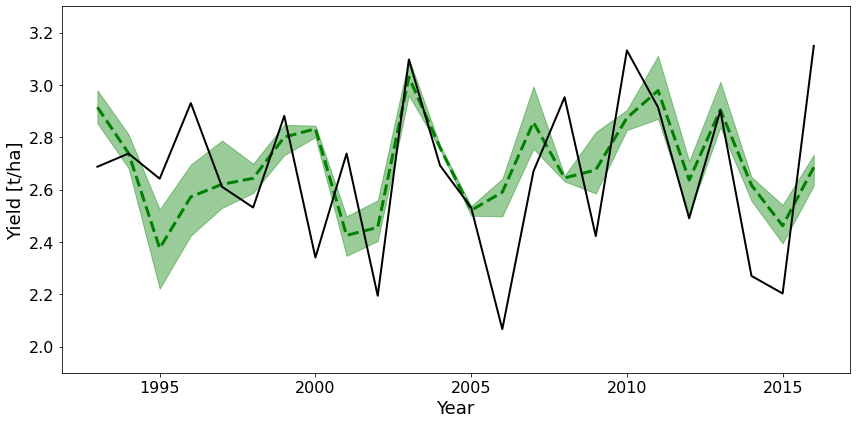

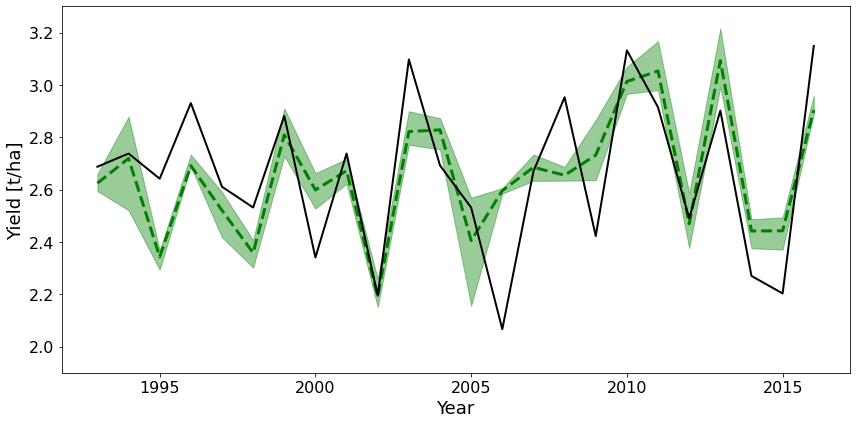

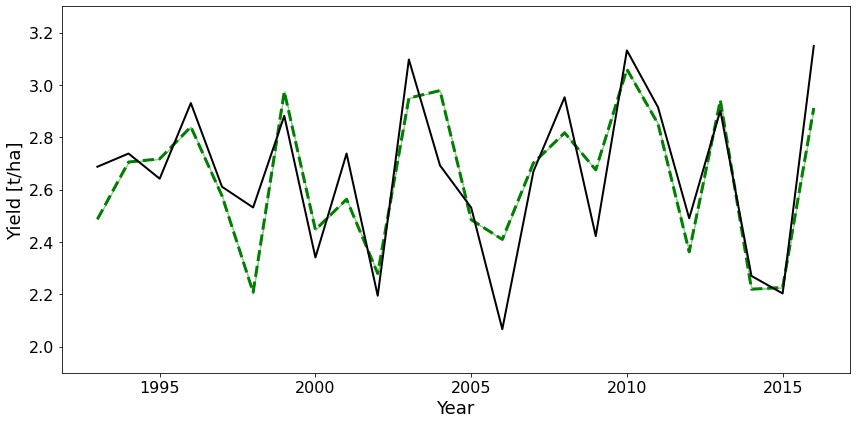

In [9]:

titles = dict(zip([6, 7, 8, 9, 10, 11], ["a) 6 (June)", "b) 7 (July)", "c) 8 (Aug)", "d) 9 (Sep)", "e) 10 (Oct)", "f) 11 (Nov)"]))
for im in list(range(6, 12)):
    #results = pd.DataFrame(0, index=models + ["OBS"], columns=list(range(1993,2017)))
    plot_sims = simulations.loc[(simulations["init_month"] == im) & (simulations["model"].isin(["MME", "ECMWF", "NCEP", "UKMO"]))].pivot(index="year", columns="model", values="predicted")
    plot_obs = simulations.iloc[:24, [0,2,3]].assign(model="OBS").pivot(index="year", columns="model", values="yield")
    plot_all = plot_sims.merge(plot_obs, on="year").apply(lambda x: x/1000)
    min_values = plot_all[["ECMWF", "NCEP", "UKMO"]].min(axis=1).values
    max_values = plot_all[["ECMWF", "NCEP", "UKMO"]].max(axis=1).values
    plt.figure(figsize=(12,6))
    
    ax = sns.lineplot(data=plot_all, x=plot_all.index, y=plot_all["MME"], linewidth=3, color="green", linestyle="--")
    sns.lineplot(data=plot_all, x=plot_all.index, y=plot_all["OBS"], linewidth=2, color="black", alpha=1)
    plt.fill_between(plot_all.index, min_values, max_values, color="green", alpha=0.4)
    ax.set_xlabel("Year", fontsize=18)
    ax.set_ylabel("Yield [t/ha]", fontsize=18)
    ax.set_ylim(1.9, 3.3)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
    name = str(titles[im])
    plt.tight_layout()
    #plt.savefig("images/" + name + ".svg")
    plt.show()

#### 3.4 Pearson R of Climate Features

In [10]:
forecast_models = ["ECMWF", "NCEP", "UKMO", "MME", "CLIMATE"]
results = pd.DataFrame(0, index=list(range(0,20)), columns=list(range(6,11)) + ["model", "variable", "metric"])
results = results.assign(model=forecast_models * 4, variable=["Tmean"]*10 + ["Rain"]*10, metric=["MAE"]*5 + ["Pearson"]*5 + ["MAE"]*5 + ["Pearson"]*5)

init_month_to_relevant_columns = {
    6: {
        "Rain": ['Rain_Sep_1', 'Rain_Sep_2', 'Rain_Sep_3', 'Rain_Sep_4'],
        "Tmean": ['Tmean_Aug_1', 'Tmean_Aug_2', 'Tmean_Aug_3', 'Tmean_Aug_4', 'Tmean_Oct_1', 'Tmean_Oct_2', 'Tmean_Oct_3', 'Tmean_Oct_4']
        },
    7: {
        "Rain": ['Rain_Sep_1', 'Rain_Sep_2', 'Rain_Sep_3', 'Rain_Sep_4'],
        "Tmean": ['Tmean_Aug_1', 'Tmean_Aug_2', 'Tmean_Aug_3', 'Tmean_Aug_4', 'Tmean_Oct_1', 'Tmean_Oct_2', 'Tmean_Oct_3', 'Tmean_Oct_4']
        },
    8: {
        "Rain": ['Rain_Sep_1', 'Rain_Sep_2', 'Rain_Sep_3', 'Rain_Sep_4'],
        "Tmean": ['Tmean_Aug_1', 'Tmean_Aug_2', 'Tmean_Aug_3', 'Tmean_Aug_4', 'Tmean_Oct_1', 'Tmean_Oct_2', 'Tmean_Oct_3', 'Tmean_Oct_4']
        },
    9: {
        "Rain": ['Rain_Sep_1', 'Rain_Sep_2', 'Rain_Sep_3', 'Rain_Sep_4'],
        "Tmean": ['Tmean_Oct_1', 'Tmean_Oct_2', 'Tmean_Oct_3', 'Tmean_Oct_4']
        },
    10: {
        "Rain": ["Rain_Aug_1"],
        "Tmean": ['Tmean_Oct_1', 'Tmean_Oct_2', 'Tmean_Oct_3', 'Tmean_Oct_4']
    }
}
for var in ["Rain", "Tmean"]:
    for im in [6, 7, 8, 9, 10]:
        for model in forecast_models:
            df_model = kfold_cv_dataset.loc[(kfold_cv_dataset["model"] == model) & (kfold_cv_dataset["init_month"] == im), init_month_to_relevant_columns[im][var]].reset_index(drop=True).copy()
            df_obs = kfold_cv_dataset.loc[(kfold_cv_dataset["model"] == "WS") & (kfold_cv_dataset["init_month"] == 11), init_month_to_relevant_columns[im][var]].reset_index(drop=True).copy()
            
            df_model = df_model.values.reshape(1, -1).flatten()
            df_obs = df_obs.values.reshape(1, -1).flatten()
            
            results.loc[(results["model"] == model) & (results["variable"] == var) & (results["metric"] == "MAE"), im] = mae(df_obs, df_model)
            results.loc[(results["model"] == model) & (results["variable"] == var) & (results["metric"] == "Pearson"), im] = pearsonr(df_obs, df_model)[0] 

results.loc[(results["variable"] == "Rain"), 10] = np.nan


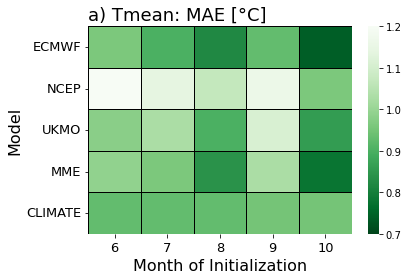

In [11]:
for m in ["MAE"]:
    for var in ["Tmean"]:
        to_plot = results.loc[(results["variable"] == var) & (results["metric"] == m), list(range(6,11))+ ["model"]].set_index("model")
        plt.figure(figsize = (6,4))
        ax = sns.heatmap(data=to_plot.round(2), vmax=1.2, vmin=0.7, annot=False, linecolor="black", linewidths=1, fmt="g", cmap="Greens_r", annot_kws={"size":12}) # 'copper', 'Greens', 'Purples'
        ax.set_xlabel("Month of Initialization", fontsize=16)
        ax.set_ylabel("Model", fontsize=16)
        ax.set_title("a) Tmean: MAE [°C]", loc="left", fontsize=18)
        ax.xaxis.set_tick_params(labelsize=13)
        ax.yaxis.set_tick_params(labelsize=13, rotation=0)
        cbar = ax.collections[0].colorbar
        cbar.set_ticks([0.7, 0.8, 0.9, 1, 1.1, 1.2])
        plt.tight_layout()
        #plt.savefig("images/tmean_mae.svg")
        plt.show();

'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'